# Complete Workflow for generating ATS input for Coweeta

This workflow provides a complete working example to develop an unstructured mesh for an integrated hydrologic model based on HUCs.  It is the default workflow for integrated hydrology simulations for Exasheds Simulation Campaign 2.

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation
* `NLCD` for land cover/transpiration/rooting depths
* `GLYHMPS` geology data for structural formations
* `SoilGrids 2017` for depth to bedrock and soil texture information
* `SSURGO` for soil data, where available, in the top 2m.

Given some basic inputs (in the next cell) including a NAME, this workflow creates the following files (noting that some suffixes may be appended to the user-provided NAME in homogeneous cases):

* Mesh file: `{NAME}.exo`, includes all labeled sets
* Forcing: DayMet data -- daily raster of precip, RH, incoming radiation, etc.
  - `{NAME}_DayMet_1910_2020.h5`, the DayMet data on this watershed
  - `{NAME}_DayMet_typical_1910_2020.h5`, a "typical year" of DayMet, smoothed for spinup purposes, then looped 40 years
* Forcing: LAI data -- every 4 days, time series by land cover type of LAI.  Note, the raw inputs to this are not done by NAME, but by an (optional, defaults to NAME) MODIS_NAME variable.  Since WW does not currently download MODIS, one might want to use a file of a different name to provide MODIS data.  The times of this MODIS data are hard-coded too -- this is all a bit wonky and will remain so until we get around to adding a file manager for MODIS data.
  - `{NAME}_MODIS_LAI_smoothed_2010_2020.h5`, the LAI, interpolated and smoothed from the raw MODIS data
  - `{NAME}_MODIS_LAI_typical_2010_2020.h5`, a "typical year" of LAI, smoothed for spinup purposes then looped 10 years
* Input files: ATS xml files
  - `spinup-steadystate-{NAME}.xml` the steady-state solution based on uniform application of mean rainfall rate
  - `spinup-cyclic_steadystate-{NAME}.xml` the cyclic steady state based on typical years
  - `transient-{NAME}.xml` the forward model


In [1]:
# these can be turned on for development work
%load_ext autoreload
%autoreload 2

## Parameters and data sources

In [2]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Coweeta' # name the domain, used in filenames, etc
hint = '0601'

# geometric parameters
simplify = 60 # length scale to target average edge
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.01 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# simulation control
start_year = 2010  # year to start and end simulation simulation -- note the run itself will actually start and end Oct 1 of the year
end_year = 2020
nyears_cyclic_steadystate = 4

# soil property control
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

# triangle refinement control
include_rivers = True
# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200
refine_A0 = refine_L0**2 / 2
refine_A1 = refine_L1**2 / 2

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

log_to_file = False  # if true, write to file instead of in the notebook output

In [3]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

In [4]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [5]:
# conda package imports
import os,sys
import numpy as np
import shapely
import copy
import logging
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)
import cftime, datetime
import pandas
pandas.options.display.max_columns = None
pandas.options.display.max_rows = None

# Watershed Workflow
import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.split_hucs
import watershed_workflow.soil_properties
import watershed_workflow.daymet
import watershed_workflow.land_cover_properties
import watershed_workflow.timeseries
import watershed_workflow.datasets


if log_to_file:
    outputs['logfile'] = f'{name}.log'
    # is this right?  the file handle will become stale... test once this is pipelined.
    with open(outputs['logfile'], 'w') as fid:
        watershed_workflow.ui.setup_logging(1,fid)
else:
    watershed_workflow.ui.setup_logging(1,None)

# ats_input_spec library, to be moved to amanzi_xml
import ats_input_spec
import ats_input_spec.public
import ats_input_spec.io

# amanzi_xml, included in AMANZI_SRC_DIR/tools/amanzi_xml
import amanzi_xml.utils.io as aio
import amanzi_xml.utils.search as asearch
import amanzi_xml.utils.errors as aerrors


In [6]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile. A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [7]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']

#
# This demo uses a few datasets that have been clipped out of larger, national
# datasets and are distributed with the code.  This is simply to save download
# time for this simple problem and to lower the barrier for trying out
# Watershed Workflow.  A more typical workflow would delete these lines (as 
# these files would not exist for other watersheds).
#
# The default versions of these download large raster and shapefile files that
# are defined over a very large region (globally or the entire US).
#
# Note we also prepopulate some data for MODIS data as well.
#
sources['land cover'] = watershed_workflow.source_list.FileManagerRaster(os.path.join('input_data', 'land_cover', 'land_cover.tif'))
sources['geologic structure'] = watershed_workflow.source_list.FileManagerGLHYMPS(os.path.join('input_data', 'GLHYMPS', 'GLHYMPS.shp'))
sources['depth to bedrock'] = watershed_workflow.source_list.FileManagerRaster(os.path.join('input_data', 'DTB', 'DTB.tif'))
watershed_workflow.source_list.log_sources(sources)


2024-05-07 14:39:27,283 - root - INFO: Using sources:
2024-05-07 14:39:27,283 - root - INFO: --------------
2024-05-07 14:39:27,284 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-05-07 14:39:27,284 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-05-07 14:39:27,284 - root - INFO: DEM: National Elevation Dataset (NED)
2024-05-07 14:39:27,284 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2024-05-07 14:39:27,284 - root - INFO: geologic structure: input_data/GLHYMPS/GLHYMPS.shp
2024-05-07 14:39:27,284 - root - INFO: land cover: raster
2024-05-07 14:39:27,284 - root - INFO: lai: MODIS
2024-05-07 14:39:27,285 - root - INFO: soil thickness: None
2024-05-07 14:39:27,285 - root - INFO: meteorology: DayMet 1km
2024-05-07 14:39:27,285 - root - INFO: depth to bedrock: raster


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Acquire the input data

Here we load the watershed, provided by the user as a shapefile, and download the river network within that shape from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [8]:
# load the watershed from shapefile
coweeta_shapefile = os.path.join('input_data', 'coweeta_basin.shp')
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2024-05-07 14:39:27,293 - root - INFO: 
2024-05-07 14:39:27,294 - root - INFO: Loading shapes
2024-05-07 14:39:27,294 - root - INFO: ------------------------------
2024-05-07 14:39:27,294 - root - INFO: Loading file: 'input_data/coweeta_basin.shp'
2024-05-07 14:39:27,303 - root - INFO: ... found 1 shapes
2024-05-07 14:39:27,304 - root - INFO: Converting to shapely
2024-05-07 14:39:27,304 - root - INFO:  ... done
2024-05-07 14:39:27,305 - root - INFO: Converting to requested CRS
2024-05-07 14:39:27,309 - root - INFO:  ... done
2024-05-07 14:39:27,310 - root - INFO: Removing holes on 1 polygons
2024-05-07 14:39:27,310 - root - INFO:   -- removed interior
2024-05-07 14:39:27,310 - root - INFO:   -- union
2024-05-07 14:39:27,310 - root - INFO: Parsing 1 components for holes
2024-05-07 14:39:27,310 - root - INFO:   -- complete


In [9]:
# download/collect the river network within that shape's bounds
_, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                            watershed.exterior(), crs, crs,
                                            in_network=True, properties=True)

# construct the dendritic tree of the river
rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                             ignore_small_rivers=ignore_small_rivers,
                                             prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                             remove_diversions=True,
                                             remove_braided_divergences=True)

# keep a copy of the originals for plotting
rivers_orig = [river.deepcopy() for river in rivers]
watershed_orig = copy.deepcopy(watershed) 


2024-05-07 14:39:27,320 - root - INFO: 
2024-05-07 14:39:27,320 - root - INFO: Loading Hydrography
2024-05-07 14:39:27,321 - root - INFO: ------------------------------
2024-05-07 14:39:27,321 - root - INFO: Loading streams in HUC 0601
2024-05-07 14:39:27,321 - root - INFO:          and/or bounds (1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)
2024-05-07 14:39:27,322 - root - INFO:   Using Hydrography file "/home/ecoon/code/watershed_workflow/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2024-05-07 14:39:27,322 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/home/ecoon/code/watershed_workflow/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)'
2024-05-07 14:39:27,410 - root - INFO:   Found total of 43 in bounds.
2024-05-07 14:39:27,410 - root - INFO: Filtering reaches not in-networ

### Resample both the River Network and Watershed

The raw line segments that form both watersheds and rivers can have subsequent coordinates that are both very close (to capture high resolution features) and very far away (when features are very straight).  To turn these into a mesh, we want all edges to be about the same length, as these edges will form the key length scale of our unstructured mesh resolution.  Therefore, we first simplify the river and watershed, which relaxes features that are too high resolution and therefore removes edges that are too short, then densify, which fills in edges that are too long.


In [10]:
# simplify
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                           snap_tol=0.75*simplify, cut_intersections=True)

# for plotting purpose only
rivers_simplified = [river.deepcopy() for river in rivers] 
watershed_simplified = copy.deepcopy(watershed) 

2024-05-07 14:39:37,467 - root - INFO: 
2024-05-07 14:39:37,467 - root - INFO: Simplifying
2024-05-07 14:39:37,467 - root - INFO: ------------------------------
2024-05-07 14:39:37,468 - root - INFO: Simplifying rivers
2024-05-07 14:39:37,471 - root - INFO: Simplifying HUCs
2024-05-07 14:39:37,472 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-05-07 14:39:37,472 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-05-07 14:39:37,473 - root - INFO:   snapping river endpoints to the polygon
2024-05-07 14:39:37,478 - root - INFO:   cutting at crossings
2024-05-07 14:39:37,479 - root - INFO: intersection found
2024-05-07 14:39:37,480 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-05-07 14:39:37,480 - root - INFO:       split HUC boundary seg into 2 pieces
2024-05-07 14:39:37,480 - root - INFO:       split reach seg into 2 pieces
2024-05-07 14:39:37,483 - root - INFO: Cutting crossings and removing external segments
2024-05-

In [11]:
# densify
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

# densify the watershed
#
# Note that the watershed boundary is densified with a variable length scale, with shorter edges near the rivers and longer edges
# away from the rivers.  This corresponds with how triangles will be refined near the river and coarser away from the river.
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

# densify the river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=70)

# nudge apart sharp angles, which otherwise introduce very small triangles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=10, junction_angle_limit=10, huc_seg_river_angle_limit=10, limit=70)

2024-05-07 14:39:37,521 - root - INFO:   river min seg length: 49.491716006188156
2024-05-07 14:39:37,521 - root - INFO:   river median seg length: 57.86231438772043
2024-05-07 14:39:37,553 - root - INFO: removing sharp angle between river and huc: 6.385078051472874 for node 25000400358462


/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240424/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240424/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240424/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from an

Text(0.5, 1.0, 'after densify')

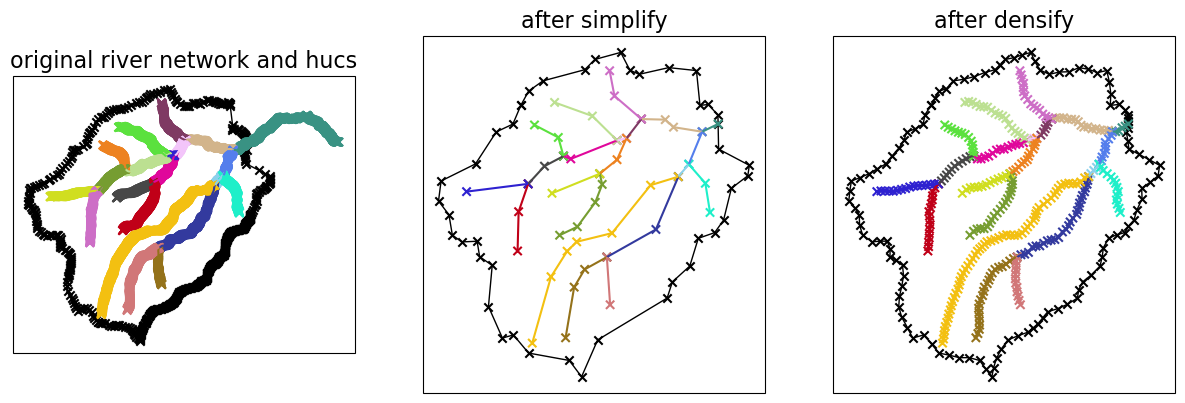

In [12]:
# visually compare the original, simplified and re-densified huc and river
fig, axs = watershed_workflow.plot.get_ax(crs, nrow=1, ncol=3)

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0], marker='x')
watershed_workflow.plot.shplys(list(rivers_orig[0]), crs, ax=axs[0], marker='x')
axs[0].set_title('original river network and hucs',fontsize=16)

watershed_workflow.plot.hucs(watershed_simplified, crs, 'k', axs[1], marker='x')
watershed_workflow.plot.shplys(list(rivers_simplified[0]), crs, ax=axs[1], marker='x')
axs[1].set_title('after simplify',fontsize=16)

watershed_workflow.plot.hucs(watershed, crs, 'k', axs[2], marker='x')
watershed_workflow.plot.shplys(list(rivers[0]), crs, ax=axs[2], marker='x')
axs[2].set_title('after densify',fontsize=16)


### Generate the mesh

We next tessalate the basin, introducing quads, pentagons, and other polygons as needed along the stream corridor, and triangles away from the stream corridor.

Triangles are refined if their area (in m^2) is greater than A(d), where d is the 
distance from the triangle centroid to the nearest stream.  A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates between the two endpoints.

2024-05-07 14:39:37,861 - root - INFO: 
2024-05-07 14:39:37,862 - root - INFO: Stream-aligned Meshing
2024-05-07 14:39:37,862 - root - INFO: ------------------------------
2024-05-07 14:39:37,862 - root - INFO: Creating stream-aligned mesh...
2024-05-07 14:39:37,862 - root - INFO: River 0
2024-05-07 14:39:37,862 - root - INFO: ... generating initial polygon through dilation (4 m)
2024-05-07 14:39:37,863 - root - INFO:   -- treating collinearity
2024-05-07 14:39:37,865 - root - INFO:   -- river min seg length: 49.491716006188156
2024-05-07 14:39:37,865 - root - INFO:   -- merging points closer than 33.491716006188156 m along the river corridor
2024-05-07 14:39:37,868 - root - INFO: ... defining river-mesh topology (quad elements)
2024-05-07 14:39:37,877 - root - INFO: ... setting width of quad elements
2024-05-07 14:39:37,880 - root - INFO: ... enforcing convexity
2024-05-07 14:39:37,882 - root - INFO: Adjusting rivers at the watershed boundaries...
2024-05-07 14:39:37,882 - root - INFO

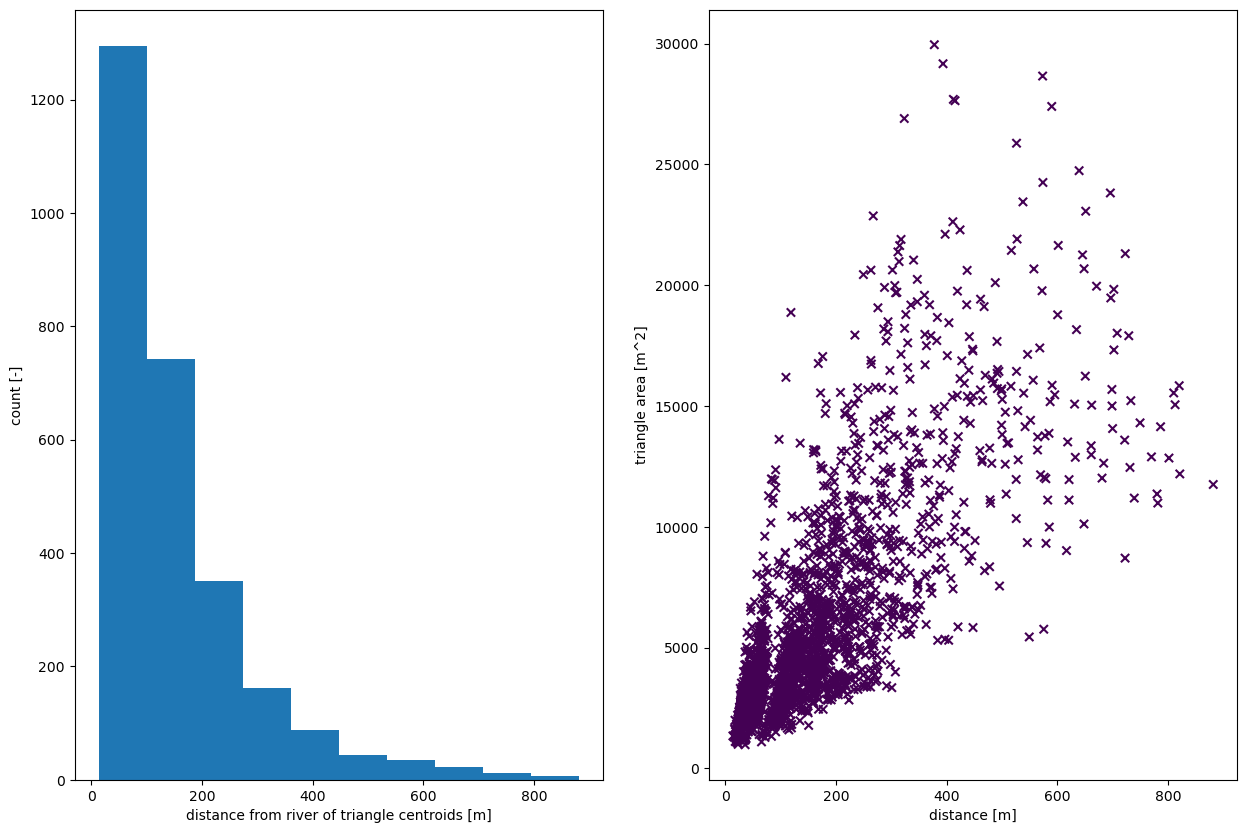

In [13]:
## Triangulation

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({1:8,2:12,3:16})

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_max_area=30000,
                                              diagnostics=True)

In [14]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2024-05-07 14:39:38,095 - root - INFO: 
2024-05-07 14:39:38,095 - root - INFO: Loading Raster
2024-05-07 14:39:38,095 - root - INFO: ------------------------------
2024-05-07 14:39:38,096 - root - INFO: Collecting raster
2024-05-07 14:39:38,101 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186388, 35.01734099944037, -83.41165773504302, 35.08381933600275]
2024-05-07 14:39:38,101 - root - INFO:   Need:
2024-05-07 14:39:38,101 - root - INFO:     /home/ecoon/code/watershed_workflow/data/dem/USGS_NED_1as_n36_w084.tif
2024-05-07 14:39:38,102 - root - INFO: source files already exist!
2024-05-07 14:39:38,112 - root - INFO: ... got raster of shape: (239, 276)
2024-05-07 14:39:38,113 - root - INFO: ... got raster bounds: (-83.48845037186388, 35.08381933600275, -83.41178370519467, 35.01743044711165)


In [15]:
# construct the 2D surface mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

### Mesh conditioning and improvement

Hydrologic conditioning is not technically necessary for a diffusion wave overland flow model, but it makes for better predictions of
inundation fraction, etc.  Furthermore, if the mesh isn't perfectly resolving the DEM, sub-grid variations in the DEM can make the mesh
dependent upon where exactly nodes fall on the DEM, which isn't desirable.  Therefore we both fill pits (away from waterbodies/lakes)
and make sure that the river elements "flow downhill."

In [16]:
# hydrologically condition the mesh, removing pits
river_mask = np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fill_pits_dual(m2, is_waterbody=river_mask)


In [17]:
# hydrologically condition the river network elements
#
# add elevations to the river tree for stream bed conditioning
watershed_workflow.condition.elevate_rivers(rivers, crs, dem, dem_profile)

# condition the river mesh using NHD elevations
watershed_workflow.condition.condition_river_mesh(m2, river)

NameError: name 'river' is not defined

In [ ]:
# plot the surface mesh with elevations
start = min(m2.centroids[:,2])
step = (max(m2.centroids[:,2]) - (min(m2.centroids[:,2]))) / 40
stop = max(m2.centroids[:,2]) + step
legend_values = np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')


fig, ax = watershed_workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2, 
                        linewidth=0.5 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='k', facecolor='color')
ax2.set_aspect('equal', 'datalim')

xlim = (1.4433e6, 1.4438e6)
ylim = (-647000, -647500)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')
cbar.ax.set_title('elevation [m]')
plt.show()

In [ ]:
# identify outlets using the hydrosequence from NHDPlus
rivers = sorted(rivers, key=len)
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[-1])

if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs, figsize=(12,10))
    colors = watershed_workflow.colors.enumerated_colors(len(watershed), palette=4)
    watershed_workflow.plot.hucs(watershed, crs, ax=ax, color=colors, linewidth=1, facecolor='color', alpha=0.4)
    watershed_workflow.plot.rivers(rivers, crs, ax=ax, colors='b', linewidth=0.5)
    watershed_workflow.plot.shplys(watershed.polygon_outlets, crs, ax=ax, color=colors, marker='o', markersize=200)

In [ ]:
# add regions:
# - regions for watershed and watershed outlet.
#  Note that one would not normally provide labels, but instead use the HUC ID, but Coweeta si from a shape not a HUC
watershed_workflow.regions.add_watershed_regions_and_outlets(m2, watershed, outlet_width=500, labels=['Coweeta',])

# add a label for the corridor
watershed_workflow.regions.add_river_corridor_regions(m2, rivers)

# note there are other useful options here, e.g. labeling by stream order (for different Manning's coefficient by stream order), etc.

In [ ]:
# print out the regions formed
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}", size = {len(ls.ent_ids)}')

## Surface properties and labeled sets

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type and quantity on the surface to provide information about transpiration.  We want both temporal change (seasonal variation) in LAI and high spatial resolution in land use.  To get this, we download MODIS data for LAI and Land Use.  But MODIS is relatively coarse (250m), so we would prefer to use NLCD (30m) for the spatial patterns.  This leads to our strategy -- use MODIS to generate LAI as a function of time for each land use type.  Then use NLCD to define where each land use type is on the mesh.  This requires a crosswalk between the two indices, which we generate by considering the correlation of their spatial patterns.


### Leaf Area Index (MODIS)
First download both LAI and Land Use from the MODIS database through the NASA AppEEARS API.  This requires a login and password, which one can register for at the DAAC site: https://lpdaac.usgs.gov/tools/appeears/

Then, place that login information in your `~/.watershed_workflowrc` file:

```
[AppEEARS]
username : USERNAME
password : PASSWORD
```

Note that this API is not immediate -- you request the data and receive a task ID, then later can query to see if your data is ready. It usually takes a few minutes to process the request (~5).

In [ ]:
startdate = f"{start_year}-1-1"
enddate = f"{end_year+1}-1-1"

# launch the request, then wait for the response.  Note that this can be done asynchronously, 
# in the sense that you could get the task, then do other work, then only call wait once
# you are done with all other work that can be done without this data.  Here we just wait
# immediately to make for cleaner, sequential instruction.
modis_task = sources['lai'].get_data(watershed.exterior().bounds, crs, startdate, enddate) 

In [ ]:
# note that occassionally the bundle is found, but then when we try to download we get a 404 error for the actual data.  In this case,
# simply try again -- usually the bundle thinks it is ready but the AWS server isn't updated yet or something...
if isinstance(modis_task, watershed_workflow.sources.manager_modis_appeears.Task):
    modis_data = sources['lai'].wait(modis_task)
else:
    modis_data = modis_task


In [ ]:
# drop data on leap day -- MODIS is real data, but we work with data on a noleap calendar.  This drops Dec 31
for dset in modis_data.collections:
    watershed_workflow.datasets.removeLeapDay(dset)

# need new start and end dates in the new calendar
startdate = cftime.datetime(start_year, 1, 1, calendar='noleap')
enddate = cftime.datetime(end_year, 12, 31, calendar='noleap')

# compute the dynamic time series
lai_df = watershed_workflow.land_cover_properties.compute_time_series(modis_data['LAI'], modis_data['LULC'], 
                                                                      polygon=watershed.exterior(), polygon_crs=crs)


In [ ]:
# plot the dynamic data
fig = plt.figure()
ax = fig.add_subplot(111)

lai_date = np.array([datetime.datetime(t.year, t.month, t.day) for t in lai_df['time [datetime]']])
for column in lai_df:
    if column != 'time [datetime]':
        ax.plot(lai_date, lai_df[column], label=column)
ax.set_ylabel('Leaf Area Index [-]')
ax.set_xlabel('time')
ax.legend()
plt.show()


In [ ]:
print(lai_df.keys())


In [ ]:
# Save that to disk
filename = os.path.join('output_data', f'{name}_modis_lai-{start_year}-{end_year}.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, lai_df, time0=startdate)
outputs[f'{name}_modis_lai_dynamic'] = filename

In [ ]:
# compute a typical year for use in spinup, saving 10 years of repeated data
#
# note that the start_year doesn't really matter for this, but it should match the Met data start date
lai_typical_df = watershed_workflow.timeseries.computeAverageYear(lai_df, output_nyears=nyears_cyclic_steadystate, 
                                                                  start_year=2010, smooth=True)

In [ ]:
# plot the typical data
fig = plt.figure()
ax = fig.add_subplot(111)

date = np.array([datetime.datetime(t.year, t.month, t.day) for t in lai_typical_df['time [datetime]']])
for column in lai_typical_df:
    if column != 'time [datetime]':
        ax.plot(date, lai_typical_df[column], label=column)
ax.set_ylabel('Leaf Area Index [-]')
ax.set_xlabel('time')
ax.legend()
plt.show()

In [ ]:
# write the typical year to disk
filename = os.path.join('output_data', f'{name}_modis_lai-typical.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, lai_typical_df, time0=lai_typical_df['time [datetime]'][0])
outputs[f'{name}_modis_lai_typical'] = filename

In [ ]:
print(list(lai_typical_df.keys()))

### Land Cover (NLCD)

Next download land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed forest.

In [ ]:
# download the NLCD raster
lc_profile, lc_raster = watershed_workflow.get_raster_on_shape(sources['land cover'], 
                                                     watershed.exterior(), crs)

# resample the raster to the mesh
lc = watershed_workflow.values_from_raster(m2.centroids, crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


In [ ]:
if generate_plots:  
    # -- get the NLCD colormap which uses official NLCD colors and labels
    nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(lc)

    fig, ax = watershed_workflow.plot.get_ax(crs)
    polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=lc, cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                                     facecolor='color', linewidth=0.5)

    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(lc)), cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 

    ax.set_title("Land Cover Index")
    ext = ax.axis('off')
    fig.savefig(os.path.join('output_data', f'{name}_land_cover_raw'))

### Form the crosswalk

Now that we have MODIS Land Use, we need to figure out what NLCD indices correspond to what MODIS indices.  This could be done via expert opinion,
but we automate this by computing the cross correlation of the two rasters.  This forms what we call the crosswalk -- the mapping from an NLCD index to what is the most likely MODIS LU/LC index.

In [ ]:
# plot both NLCD and MODIS to form the image cross-correlation
if generate_plots:
    axs = []
    fig, a0 = watershed_workflow.plot.get_ax(lc_profile['crs'], nrow=1, ncol=2, index=1, figsize=(15,5))
    axs.append(a0) 
    
    # plot the image
    # -- get the NLCD colormap which uses official NLCD colors and labels
    nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
                watershed_workflow.colors.generate_nlcd_colormap(np.unique(lc_raster))
    
    im = watershed_workflow.plot.raster(lc_profile, lc_raster, ax=axs[0], cmap=nlcd_cmap, norm=nlcd_norm)
    watershed_workflow.plot.shply(watershed_workflow.warp.shply(watershed.exterior(), crs, lc_profile['crs']), lc_profile['crs'], 'k', axs[0])
    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(lc_raster)), cmap=nlcd_cmap, labels=nlcd_labels, ax=axs[0]) 
    axs[0].set_title("NLCD Index")
    
    
    modis_raster = modis_data['LULC'].data[-1]
    modis_profile = modis_data['LULC'].profile
    
    a1 = watershed_workflow.plot.get_ax(modis_profile['crs'], nrow=1, ncol=2, index=2, fig=fig)
    axs.append(a1)
    
    modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
                watershed_workflow.colors.generate_modis_colormap(np.unique(modis_raster))
    print(modis_indices, modis_labels)
    print(modis_cmap(8))
    print(modis_cmap(4))
    im = watershed_workflow.plot.raster(modis_profile, modis_raster, ax=axs[1], cmap=modis_cmap, norm=modis_norm)
    watershed_workflow.plot.shply(watershed_workflow.warp.shply(watershed.exterior(), crs, modis_profile['crs']), modis_profile['crs'], 'k', axs[1])
    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(modis_raster)), cmap=modis_cmap, labels=modis_labels, ax=axs[1]) 
    axs[1].set_title("MODIS LULC Index")

In [ ]:
# form the crosswalk and plot a correlation matrix
#
# note that for Coweeta, it is fairly simple because MODIS identifieds everthing as 4 (Broad leaf deciduous)
crosswalk = watershed_workflow.land_cover_properties.compute_crosswalk_correlation(modis_data['LULC'].profile, modis_data['LULC'].data[-1],
                                                                                   lc_profile, lc_raster)

print(crosswalk)

In [ ]:
# we now have to choose how to map from these NLCD indices to the MODIS LAI
#
# first, the bare ground, 0 LAI indices.  Note we could choose to treat some of these 
# differently (particularly developed land) but don't here.
others = [0, 11, 12, 21, 22, 23, 24, 31]

nlcd_color_new =  99 * np.ones_like(lc)

# we are also going to choose to downsample NLCD to just two types -- forest and other
for index in np.unique(lc):
    if index not in others:
        nlcd_color_new[np.where(lc == index)] = watershed_workflow.source_list.FileManagerNLCD.indices['Deciduous Forest']
    
# then we manually set the crosswalk:
nlcd_crosswalk_modis = {'Deciduous Forest' : watershed_workflow.source_list.FileManagerMODISAppEEARS.colors[4][0]}
print(nlcd_crosswalk_modis)                       

In [ ]:
# plot the updated image, adding "other", which mostly picks up roads and the barren land around them
nlcd_color_new_other_as_water = np.where(nlcd_color_new == 99, 11, nlcd_color_new)

# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
            watershed_workflow.colors.generate_nlcd_colormap(nlcd_color_new_other_as_water)

# make (water, 11) into (other, 99)
nlcd_labels[0] = 'Other'
nlcd_indices[0] = 99

if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs)


    polys = watershed_workflow.plot.mesh(m2, crs, ax=ax, color=nlcd_color_new_other_as_water, 
                           cmap=nlcd_cmap, norm=nlcd_norm, edgecolor='none', 
                           facecolor='color', linewidth=0.5)

    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_color_new_other_as_water)), 
                               cmap=nlcd_cmap, labels=nlcd_labels, ax=ax) 

    ax.set_title("Land Cover Index")
    ext = ax.axis('off')



### Add surface land cover type labeled sets to the mesh

Lastly, we can add these two land use types to the mesh, so that we can refer to them for LAI as a function of time in the ATS run.

In [ ]:
# add labeled sets to the mesh for NLCD
nlcd_labels_dict = dict(zip(nlcd_indices, nlcd_labels))
watershed_workflow.regions.add_nlcd_labeled_sets(m2, nlcd_color_new, nlcd_labels_dict)

In [ ]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

## Subsurface properties

Next we develop the subsurface structure model. We use a three-layer model: soil, on top of geologic material, on top of bedrock.  The soil layer is informed by the NRCS-Soils database, which only goes to 2m deep.  The geologic layer is informed by the GLHYMPs database, which is used from the bottom of the soil (2m or less) to the top of the bedrock, which is determined by the SoilGrids database's depth to bedrock product.

We download all three need data products, integrated vertically as needed, and apply them horizontally.

### Soil data

In [ ]:
# download the NRCS soils data as shapes and project it onto the mesh
#
soil_profile, soil_survey, soil_survey_props = \
        watershed_workflow.get_shapes(sources['soil structure'], list(watershed.polygons()), crs, 
                                                     crs, properties=True)

# -- determine the NRCS mukey for each soil unit; this uniquely identifies soil 
#    properties
soil_ids = list(soil_survey_props['mukey'][:])
soil_survey_props.set_index('mukey', inplace=True)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
soil_color_profile, soil_color_raster = watershed_workflow.color_raster_from_shapes(soil_survey, crs, soil_ids,
                                                                                    watershed.exterior().bounds, 10, crs, -1)

# -- resample the raster to the triangles
soil_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         soil_color_raster, soil_color_profile)


In [ ]:
soil_survey_props


In [ ]:
if generate_plots:
    # plot the soil mukey
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color, cmap='tab20c')
    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=soil_color, 
                            cmap=cmap, norm = norm
                           )

    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color)), cmap=cmap, labels=labels, ax=ax) 

    ax.set_title('soil type index')
    ax.axis('off')


In [ ]:
# what does soil thickness look like?  Note it will always be 2m or less.
soil_thickness = np.nan * np.ones(soil_color.shape, 'd')
for mukey in soil_survey_props.index:
    soil_thickness[soil_color == mukey] = soil_survey_props.loc[mukey,'thickness [cm]']

soil_thickness = soil_thickness / 100.0
soil_thickness = np.where(np.isnan(soil_thickness), 2.0, soil_thickness)
print(soil_thickness.max(), soil_thickness.min())

if generate_plots:
    fig, ax = watershed_workflow.plot.get_ax(crs)
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=soil_thickness)
    ax.set_title('soil thickness [m]')
    cb = fig.colorbar(mp, fraction=0.04, pad=0.04)
    ax.axis('off')

print('Median soil thickness [-] = ', np.median(soil_thickness))



In [ ]:
if generate_plots:
    # plot of porosity from SSURGO
    iprop = np.empty(soil_color.shape, 'd')
    for mukey in soil_survey_props.index:
        iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'porosity [-]']

    fig, ax = watershed_workflow.plot.get_ax(crs)
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=iprop, cmap='jet')

    ax.set_title('soil porosity [-]')
    cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend="both", shrink=0.6)
    ax.axis('off')

    print('Median porosity [-] = ', np.nanmedian(iprop))


In [ ]:
if generate_plots:
    # plot of permeability
    iprop = np.empty(soil_color.shape, 'd')
    for mukey in soil_survey_props.index:
        iprop[soil_color == mukey] = soil_survey_props.loc[ mukey,'permeability [m^2]']

    fig, ax = watershed_workflow.plot.get_ax(crs)
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=iprop, cmap='jet')
    ax.set_title('soil permeability [-]')
    cb = fig.colorbar(mp, fraction=0.04, pad=0.04, extend="both", shrink=0.6)
    cb.ax.set_title('log K')
    ax.axis('off')

    print('Min k [m^2] = ', np.nanmin(iprop))


In [ ]:
# Note there is potential for missing data (white).  This is because some SSURGO map units have no formation with complete 
# information.  So we merge the above available data, filling where possible and dropping regions that
# do not have a complete set of properties.
soil_survey_props_clean = soil_survey_props.reset_index()

# later scripts expect 'native_index' as a standard name of holding onto the original IDs
soil_survey_props_clean.rename_axis('native_index', inplace=True)
soil_survey_props_clean.rename(columns={'mukey':'native_index'}, inplace=True)

# need thickness in m
soil_survey_props_clean['thickness [cm]'] = soil_survey_props_clean['thickness [cm]']/100.
soil_survey_props_clean.rename(columns={'thickness [cm]':'thickness [m]'}, inplace=True)


def replace_column_nans(df, col_nan, col_replacement):
    """In a df, replace col_nan entries by col_replacement if is nan.  In Place!"""
    row_indexer = df[col_nan].isna()
    df.loc[row_indexer, col_nan] = df.loc[row_indexer, col_replacement]
    return

# where poro or perm is nan, put Rosetta poro
replace_column_nans(soil_survey_props_clean, 'porosity [-]', 'Rosetta porosity [-]')
replace_column_nans(soil_survey_props_clean, 'permeability [m^2]', 'Rosetta permeability [m^2]')

# drop unnecessary columns
for col in ['Rosetta porosity [-]', 'Rosetta permeability [m^2]', 'bulk density [g/cm^3]', 'total sand pct [%]',
            'total silt pct [%]', 'total clay pct [%]']:
    soil_survey_props_clean.pop(col)
    
# drop nans
soil_survey_props_clean.dropna(inplace=True)
soil_survey_props_clean.reset_index(drop=True, inplace=True)

assert soil_survey_props_clean['porosity [-]'][:].min() >= min_porosity
assert soil_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
soil_survey_props_clean


In [ ]:
# create a new soil_color, keeping on those that are kept here and re-indexing to ATS indices
soil_color_new = -np.ones_like(soil_color)
for new_id, mukey in enumerate(soil_survey_props_clean['native_index']):
    soil_color_new[np.where(soil_color == mukey)] = 1000+new_id
 
generate_plots = True
if generate_plots:
    # image the new soil_color
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(soil_color_new, cmap='tab20c')
    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=soil_color_new, 
                        cmap=cmap, norm=norm)

    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(soil_color_new)), cmap=cmap, labels=labels, ax=ax) 

    ax.set_title('soil type index')
    ax.axis('off')


### GLYHMPS geologic layer

GLYHMPS is complete in that it does not appear to have missing data, but does not have texture properties needed for Water Retention Models.  Instead we rely on scaling laws to fill the data.

In [ ]:
# extract the GLYHMPS geologic structure data as shapes and project it onto the mesh
target_bounds = watershed.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))

_, geo_survey, geo_survey_props = watershed_workflow.get_shapes(sources['geologic structure'], 
                                                      target_bounds, crs, crs, properties=True,
                                                      min_porosity=min_porosity, 
                                                      max_permeability=max_permeability,
                                                      max_vg_alpha=max_vg_alpha)

# -- log the bounds targeted and found
logging.info('shape union bounds: {}'.format(
    shapely.ops.cascaded_union(geo_survey).bounds))

# -- determine the ID for each soil unit; this uniquely identifies formation
#    properties
geo_ids = np.array([shp.properties['id'] for shp in geo_survey], np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much 
#    more efficient)
geo_color_profile, geo_color_raster = \
            watershed_workflow.color_raster_from_shapes(geo_survey, crs, geo_ids,
                                                        target_bounds, 10, crs, -1)

# -- resample the raster to the triangles
geo_color = watershed_workflow.values_from_raster(m2.centroids, crs, 
                                         geo_color_raster, geo_color_profile)


In [ ]:
# select the properties that appear in the mesh
geo_survey_props.set_index('id', inplace=True, drop=False)
geo_survey_props = geo_survey_props.loc[np.unique(geo_color), :]

In [ ]:
if generate_plots:
    # plot the geologic formation id
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color, cmap='tab20b')

    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color, 
                        cmap=cmap, norm=norm)

    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color)), cmap=cmap, labels=labels, ax=ax) 

    ax.set_title('geol type index')
    ax.axis('off')


In [ ]:
if generate_plots:
    # plot permeability of the underlying geologic layer
    iprop = np.empty(geo_color.shape, 'd')
    for i in geo_survey_props.index:
        iprop[geo_color == i] = geo_survey_props.loc[i, 'permeability [m^2]']
    
    fig, ax = watershed_workflow.plot.get_ax(crs)
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=iprop, cmap='jet')
    cbar = fig.colorbar(mp, shrink=0.5)
    ax.set_title('geology log permeability [m^2]')
    ax.axis('off')



In [ ]:
if generate_plots:
    # plot porosity of the geologic layer
    iprop = np.empty(geo_color.shape, 'd')
    for i in geo_survey_props.index:
        iprop[geo_color == i] = geo_survey_props.loc[i, 'porosity [-]']

    fig, ax = watershed_workflow.plot.get_ax(crs)
    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=iprop, cmap='jet')
    cbar = fig.colorbar(mp, shrink=0.5)
    ax.set_title('geology porosity [-]')
    ax.axis('off')


In [ ]:
# note that for larger areas there are often common regions -- two labels with the same properties -- no need to duplicate those with identical values.
geo_survey_props_clean = geo_survey_props.copy()
geo_survey_props_clean.pop('logk_stdev [-]')
geo_survey_props_clean.rename(columns={'id':'native_index'}, inplace=True)


def reindex_remove_duplicates(df, index=None):
    """Removes duplicates, creating a new index and saving the old index as tuples of duplicate values. In place!"""
    if index is not None:
        if index in df:
            df.set_index(index, drop=True, inplace=True)
    
    index_name = df.index.name

    # identify duplicate rows
    duplicates = list(df.groupby(list(df)).apply(lambda x: tuple(x.index)))

    # order is preserved
    df.drop_duplicates(inplace=True)
    df.reset_index(inplace=True)
    df[index_name] = duplicates
    return

reindex_remove_duplicates(geo_survey_props_clean, 'native_index')
assert geo_survey_props_clean['porosity [-]'][:].min() >= min_porosity
assert geo_survey_props_clean['permeability [m^2]'][:].max() <= max_permeability
assert geo_survey_props_clean['van Genuchten alpha [Pa^-1]'][:].max() <= max_vg_alpha

geo_survey_props_clean

In [ ]:
# create a new geologic layer color, keeping on those that are kept here and re-indexing to ATS indices
geo_color_new = -np.ones_like(geo_color)
for new_id, old_id_dups in enumerate(geo_survey_props_clean['native_index']):
    for old_id in old_id_dups:
        geo_color_new[np.where(geo_color == old_id)] = 100+new_id
    
if generate_plots:
    # image the new geo_color
    indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(geo_color_new, cmap='tab20c')
    fig, ax = watershed_workflow.plot.get_ax(crs)

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                        linewidth=0, color=geo_color_new, 
                        cmap=cmap, norm=norm)

    watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(geo_color_new)), cmap=cmap, labels=labels, ax=ax) 

    ax.set_title('geologic type index')
    ax.axis('off')


In [ ]:
assert(geo_color_new.min() > 0)

### Depth-to-bedrock

Depth to bedrock is taken from the [SoilGrids](http://globalchange.bnu.edu.cn/research/dtb.jsp) product.  Here we download a US-based, clipped version of this global product, as file sizes are quite large (all products potentially used total over 100GB).

In [ ]:
DTB_profile, DTB_raster = watershed_workflow.get_raster_on_shape(sources['depth to bedrock'], watershed.exterior(), crs, 
                                                       nodata=-99999)

# resample the raster to the triangles
DTB_raster = DTB_raster / 100 # convert cm --> m
DTB = watershed_workflow.values_from_raster(m2.centroids, crs, DTB_raster, DTB_profile, algorithm='piecewise bilinear')
DTB = np.where(DTB >= 0, DTB, np.nan)

In [ ]:
if generate_plots:
    # plot the resulting surface mesh
    fig, ax = watershed_workflow.plot.get_ax(crs, window=[0.05,0.1,0.9,0.8])
    cbax = fig.add_axes([.95,0.1,0.05,0.8])

    mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, facecolor='color',
                            linewidth=0, color=DTB, cmap='jet')
    cbar = fig.colorbar(mp, orientation="vertical", cax=cbax)
    watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)

    ax.set_aspect('equal', 'datalim')
    ax.axis('off')

    cbar.ax.set_title('DTB [m]')

### A combined, complete product

As a default, we would like a material-driven (e.g. not fields for porosity, perm, etc, but soil classes, each with a common porosity/permeability/vG curve) default that is valid everywhere.  That makes it clear that we must rely on GLHYMPS as the only material-based product that is valid everywhere.  Other products may be layered on top of this, replacing GLHYMPS values, but the underlying layer should be based on GLHYMPS.  To fill in the van Genuchten properties, we relate alpha to permeability and choose a single common n and s_r.

Where available, we then choose to use SSURGO as a layer on top of GLHYMPS.  So start by using all GLHYMPS values, then override ones where SSURGO is valid with those values.  This will be the second model, and has then three layers -- a bedrock layer, a soil layer from 0 to 2m, and a geologic layer, using GLHYMPS values.  SoilGrids depth-to-bedrock will be used to provide the transition between bedrock and (where > 2m) the GLHYMPS "geologic" layer or (where < 2m) the SSURGO "soil" layer.  Where SSURGO has no values, the underlying GLHYMPS values will be used even in the top 2m.


Note, all integer IDs in mesh files must be unique.  This includes Material IDs, side sets, etc.  We create the Material ID map and data frame.  This is used to standardize IDs from multiple data sources.  Traditionally, ATS numbers Material IDs/Side Sets as:

* 0-9 : reserved for boundaries, surface/bottom, etc
* 10-99 : Land Cover side sets, typically NLCD IDs are used
* 100-999 : geologic layer material IDs. 999 is reserved for bedrock.
* 1000-9999 : soil layer material IDs




In [ ]:
# map SSURGO mukey to ATS_ID
soil_survey_props_clean['ats_id'] = range(1000, 1000+len(soil_survey_props_clean))
soil_survey_props_clean.set_index('ats_id', inplace=True)

# map GLHYMPS id to ATS_ID
geo_survey_props_clean['ats_id'] = range(100, 100+len(geo_survey_props_clean))
geo_survey_props_clean.set_index('ats_id', inplace=True)

bedrock_props = watershed_workflow.soil_properties.get_bedrock_properties()

# merge the properties databases
subsurface_props = pandas.concat([geo_survey_props_clean,
                                  soil_survey_props_clean,
                                  bedrock_props])

# save the properties to disk for use in generating input file
outputs['subsurface_properties_filename'] = os.path.join('output_data', f'{name}_subsurface_properties.csv')
subsurface_props.to_csv(outputs['subsurface_properties_filename'])
subsurface_props


## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

The most difficult aspect of extrusion is creating meshes that:
1. aren't huge numbers of cells
2. aren't huge cell thicknesses, especially near the surface
3. follow implied interfaces, e.g. bottom of soil and bottom of geologic layer

This is an iterative process that requires some care and some art.

In [ ]:
# here we choose the bottom of the domain to be the maximum of the depth to bedrock.  
# This is really up to the user, but we are hard-coding this for this watershed_workflow.
dtb_max = np.nanmax(DTB)
DTB = np.where(np.isnan(DTB), dtb_max, DTB)

total_thickness = np.ceil(DTB.max())
print(f'total thickness: {total_thickness} m')

total_thickness = 41.0

In [ ]:
# Generate a dz structure for the top 2m of soil
#
# here we try for 10 cells, starting at 5cm at the top and going to 50cm at the bottom of the 2m thick soil
dzs, res = watershed_workflow.mesh.optimize_dzs(0.05, 0.5, 2, 10)
print(dzs)
print(sum(dzs))

In [ ]:
# this looks like it would work out, with rounder numbers:
dzs_soil = [0.05, 0.05, 0.05, 0.12, 0.23, 0.5, 0.5, 0.5]
print(sum(dzs_soil))

In [ ]:
# 41m total thickness, minus 2m soil thickness, leaves us with 39 meters to make up.
# optimize again...
dzs2, res2 = watershed_workflow.mesh.optimize_dzs(1, 10, 39, 8)
print(dzs2)
print(sum(dzs2))

# how about...
dzs_geo = [1.0, 3.0, 5.0,] + 3*[10.0,]
print(dzs_geo)
print(sum(dzs_geo))

In [ ]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

# -- soil layer --
depth = 0
for dz in dzs_soil:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        # use glhymps params
        br_or_geo = np.where(depth < DTB, geo_color_new, 999)
        soil_or_br_or_geo = np.where(np.bitwise_and(soil_color_new > 0, depth < soil_thickness),
                                 soil_color_new,
                                 br_or_geo)
    else:
        # use ssurgo down to DTB if it exists
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        soil_or_br_or_geo = np.where(depth < DTB, soil_or_geo, 999)
    layer_mat_ids.append(soil_or_br_or_geo)
    depth += 0.5 * dz
    
# -- geologic layer --
for dz in dzs_geo:
    depth += 0.5 * dz
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    
    if use_geologic_layer:
        geo_or_br = np.where(depth < DTB, geo_color_new, 999)
    else:
        # only soil, no geo
        soil_or_geo = np.where(soil_color_new > 0, soil_color_new, geo_color_new)
        geo_or_br = np.where(depth < DTB, soil_or_geo, 999)
        
    layer_mat_ids.append(geo_or_br)
    depth += 0.5 * dz

# print the summary
watershed_workflow.mesh.Mesh3D.summarize_extrusion(layer_types, layer_data, 
                                            layer_ncells, layer_mat_ids)

# downselect subsurface properties to only those that are used
layer_mat_id_used = list(np.unique(np.array(layer_mat_ids)))
subsurface_props_used = subsurface_props.loc[layer_mat_id_used]
len(subsurface_props_used)


In [ ]:
# extrude
m3 = watershed_workflow.mesh.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, 
                                             layer_ncells, layer_mat_ids)

In [ ]:
print('2D labeled sets')
print('---------------')
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D labeled sets')
print('------------------------')
for ls in m3.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')

print('')
print('Extruded 3D side sets')
print('---------------------')
for ls in m3.side_sets:
    print(f'{ls.setid} : FACE : {len(ls.cell_list)} : "{ls.name}"')
    


In [ ]:
# save the mesh to disk
outputs['mesh_filename'] = os.path.join('output_data',f'{name}.exo')
try:
    os.remove(outputs['mesh_filename'])
except FileNotFoundError:
    pass
m3.write_exodus(outputs['mesh_filename'])


## Meteorological forcing dataset

In addition to the LAI covered above, ATS is driven by meteorological forcing data.  We need two forcing datasets -- the actual time series and a typical year for use in spinup.


In [ ]:
startdate = f"{start_year}-1-1"
enddate = f"{end_year}-1-1"
bounds = watershed.exterior().bounds

# download the data
met_data_raw = sources['meteorology'].get_data(bounds, crs, startdate, enddate)

# write raw data to HDF5
filename = os.path.join('output_data', f'{name}_daymet-raw.h5')
outputs['meteorology_raw'] = filename
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_raw, 
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))


In [ ]:
# convert and write ATS format for transient run
met_data_transient = watershed_workflow.daymet.convertToATS(met_data_raw)


In [ ]:
# plot a few of the met data -- does it look reasonable?
date = np.array([datetime.datetime(t.year, t.month, t.day) for t in met_data_transient.times])
            
fig, axs = plt.subplots(1,2)
axs[0].plot(date, met_data_transient['precipitation rain [m s^-1]'].data[:,5,5])
axs[0].set_ylabel('rain [m d^-1]')

axs[1].plot(date, met_data_transient['incoming shortwave radiation [W m^-2]'].data[:,5,5], 'r')
axs[1].set_ylabel('incoming shortwave radiation [W m^-2]')

In [ ]:
# write transient data to disk
filename = os.path.join('output_data', f'{name}_daymet-{start_year}-{end_year}.h5')
outputs['transient meteorology'] = filename
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_transient,
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))

In [ ]:
# compute the typical year of the _raw_ data
# note that we set interpolate to False, since met_data is already daily on a noleap calendar
met_data_raw_avg = watershed_workflow.datasets.computeAverageYear(met_data_raw, nyears_cyclic_steadystate, smooth=False, 
                                                                  smooth_kwargs=dict(window_length=181, polyorder=2),
                                                                  interpolate=False)

# smoothing precipitation doesn't work -- even averaging precip doesn't work because both result in more events of lower
# intensity.  Instead, we pick the median year and repeat that nyears_cyclic_steadystate times
precip_raw = met_data_raw['prcp'].data
shape_xy = precip_raw.shape[1:]
precip_raw = precip_raw.reshape((-1, 365,)+shape_xy)
annual_precip_raw = precip_raw.sum(axis=(1,2,3))

# note -- don't use np.median here... for even number of years it will not appear.  Instead, sort and talk the halfway point
median_i = sorted(((i,v) for (i,v) in enumerate(annual_precip_raw)), key=lambda x : x[1])[len(annual_precip_raw)//2][0]
typical_precip_raw = precip_raw[median_i]
met_data_raw_avg['prcp'] = np.tile(typical_precip_raw, (nyears_cyclic_steadystate,1,1))


In [ ]:
# convert the typical year to ATS
met_data_avg = watershed_workflow.daymet.convertToATS(met_data_raw_avg)

In [ ]:
# plot a few of the met data -- does it look reasonable?
fig, axs = plt.subplots(1,2)
date = np.array([datetime.datetime(t.year, t.month, t.day) for t in met_data_avg.times])

axs[0].plot(date, met_data_avg['precipitation rain [m s^-1]'].data[:,5,5], label='rain')
axs[0].plot(date, met_data_avg['precipitation snow [m SWE s^-1]'].data[:,5,5], label='snow')
axs[0].legend()
axs[0].set_ylabel('precip [m d^-1]')

axs[1].plot(date, met_data_avg['incoming shortwave radiation [W m^-2]'].data[:,5,5], 'r')
axs[1].set_ylabel('incoming shortwave radiation [W m^-2]')

In [ ]:
# write cyclic steadystate data to disk
filename = os.path.join('output_data', f'{name}_daymet-typical.h5')
outputs['cyclic steadystate meteorology'] = filename
watershed_workflow.io.write_dataset_to_hdf5(
    filename,
    met_data_avg,
    watershed_workflow.daymet.getAttributes(bounds, startdate, enddate))


In [ ]:
# compute the average precip rate for steadystate solution
precip_mean = (met_data_transient['precipitation rain [m s^-1]'].data + met_data_transient['precipitation snow [m SWE s^-1]'].data).mean()
logging.info(f'Mean precip value = {precip_mean}')


## Write ATS input files

In [ ]:
# Note that each of these are defined as functions so we can reuse them for all three input files.

# add the subsurface and surface domains
#
# Note this also adds a "computational domain" region to the region list, and a vis spec 
# for "domain"
def add_domains(main_list, mesh_filename, surface_region='surface', snow=True, canopy=True):
    ats_input_spec.public.add_domain(main_list, 
                                 domain_name='domain', 
                                 dimension=3, 
                                 mesh_type='read mesh file',
                                 mesh_args={'file':mesh_filename})
    if surface_region:
        main_list['mesh']['domain']['build columns from set'] = surface_region    
    
        # Note this also adds a "surface domain" region to the region list and a vis spec for 
        # "surface"
        ats_input_spec.public.add_domain(main_list,
                                domain_name='surface',
                                dimension=2,
                                mesh_type='surface',
                                mesh_args={'surface sideset name':'surface'})
    if snow:
        # Add the snow and canopy domains, which are aliases to the surface
        ats_input_spec.public.add_domain(main_list,
                                domain_name='snow',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})
    if canopy:
        ats_input_spec.public.add_domain(main_list,
                                domain_name='canopy',
                                dimension=2,
                                mesh_type='aliased',
                                mesh_args={'target':'surface'})


In [ ]:
def add_land_cover(main_list):
    # next write a land-cover section for each NLCD type
    for index, nlcd_name in zip(nlcd_indices, nlcd_labels):
        ats_input_spec.public.set_land_cover_default_constants(main_list, nlcd_name)

    land_cover_list = main_list['state']['initial conditions']['land cover types']
    # update some defaults for
    # ['Other', 'Deciduous Forest']
    # note, these are from the CLM Technical Note v4.5
    #
    # Rooting depth curves from CLM TN 4.5 table 8.3
    #
    # Note, the mafic potential values are likely pretty bad for the types of van Genuchten 
    # curves we are using (ETC -- add paper citation about this topic).  Likely they need
    # to be modified.  Note that these values are in [mm] from CLM TN 4.5 table 8.1, so the 
    # factor of 10 converts to [Pa]
    #
    # Note, albedo of canopy taken from CLM TN 4.5 table 3.1
    land_cover_list['Deciduous Forest']['rooting profile alpha [-]'] = 6.0
    land_cover_list['Deciduous Forest']['rooting profile beta [-]'] = 2.0
    land_cover_list['Deciduous Forest']['rooting depth max [m]'] = 10.0
    land_cover_list['Deciduous Forest']['capillary pressure at fully closed stomata [Pa]'] = 224000
    land_cover_list['Deciduous Forest']['capillary pressure at fully open stomata [Pa]'] = 35000 * .10
    land_cover_list['Deciduous Forest']['albedo of canopy [-]'] = 0.1



In [ ]:
# add soil sets: note we need a way to name the set, so we use, e.g. SSURGO-MUKEY.
def soil_set_name(ats_id):
    if ats_id == 999:
        return 'bedrock'
    source = subsurface_props_used.loc[ats_id]['source']
    native_id = subsurface_props_used.loc[ats_id]['native_index']
    if type(native_id) in [tuple,list]:
        native_id = native_id[0]
    return f"{source}-{native_id}"


# get an ATS "main" input spec list -- note, this is a dummy and is not used to write any files yet
def get_main():
    main_list = ats_input_spec.public.get_main()

    # add the mesh and all domains
    mesh_filename = os.path.join('..', outputs['mesh_filename'])
    add_domains(main_list, mesh_filename)

    # add labeled sets
    for ls in m3.labeled_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ls.name, ls.setid, mesh_filename, ls.entity)
    for ss in m3.side_sets:
        ats_input_spec.public.add_region_labeled_set(main_list, ss.name, ss.setid, mesh_filename, 'FACE')
    
    # add land cover
    add_land_cover(main_list)

    # add soil material ID regions, porosity, permeability, and WRMs
    for ats_id in subsurface_props_used.index:
        props = subsurface_props_used.loc[ats_id]
        set_name = soil_set_name(ats_id)
        
        if props['van Genuchten n [-]'] < 1.5:
            smoothing_interval = 0.01
        else:
            smoothing_interval = 0.0
        
        ats_input_spec.public.add_soil_type(main_list, set_name, ats_id, mesh_filename,
                                            float(props['porosity [-]']),
                                            float(props['permeability [m^2]']), 1.e-7,
                                            float(props['van Genuchten alpha [Pa^-1]']),
                                            float(props['van Genuchten n [-]']),
                                            float(props['residual saturation [-]']),
                                            float(smoothing_interval))
        
    # add observations for each subcatchment for transient runs
    ats_input_spec.public.add_observations_water_balance(main_list, "computational domain", 
                                                         "surface domain", "external_sides")

    return main_list


In [ ]:
def populate_basic_properties(xml, main_xml):
    """This function updates an xml object with the above properties for mesh, regions, soil props, and lc props"""
    # find and replace the mesh list
    xml.replace('mesh', asearch.child_by_name(main_xml, 'mesh'))

    # find and replace the regions list
    xml.replace('regions', asearch.child_by_name(main_xml, 'regions'))
    
    # update all model parameters lists
    xml_parlist = asearch.find_path(xml, ['state', 'model parameters'], no_skip=True)
    for parlist in asearch.find_path(main_xml, ['state', 'model parameters'], no_skip=True):
        try:
            xml_parlist.replace(parlist.getName(), parlist)
        except aerrors.MissingXMLError:
            xml_parlist.append(parlist)

    # update all evaluator lists
    xml_elist = asearch.find_path(xml, ['state', 'evaluators'], no_skip=True)
    for elist in asearch.find_path(main_xml, ['state', 'evaluators'], no_skip=True):
        try:
            xml_elist.replace(elist.getName(), elist)
        except aerrors.MissingXMLError:
            xml_elist.append(elist)    
    
    # find and replace land cover
    consts_list = asearch.find_path(xml, ['state', 'initial conditions'])
    lc_list = asearch.find_path(main_xml, ['state', 'initial conditions', 'land cover types'], no_skip=True)
    
    try:
        consts_list.replace('land cover types', lc_list)
    except aerrors.MissingXMLError:
        consts_list.append(lc_list)


For the first file, we load a spinup template and write the needed quantities into that file, saving it to the appropriate run directory.  Note there is no DayMet or land cover or LAI properties needed for this run.  The only property that is needed is the domain-averaged, mean annual rainfall rate.  We then take off some for ET (note too wet spins up faster than too dry, so don't take off too much...).

In [ ]:
def write_spinup_steadystate(name, precip_mean, **kwargs):
    # create the main list
    main = get_main()

    # set precip to 0.6 * the mean precip value
    precip = main['state']['evaluators'].append_empty('surface-precipitation')
    precip.set_type('independent evaluator constant', ats_input_spec.public.known_specs['independent-variable-constant-evaluator-spec'])
    precip['value'] = float(precip_mean * .6)

    
    # load the template file
    prefix = 'steadystate'
    xml = aio.fromFile(os.path.join('input_data', f'{prefix}-template.xml'))
    
    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)

    # write to disk
    outputs[f'{prefix}_{name}_filename'] = f'{name}-{prefix}.xml'
    filename = outputs[f'{prefix}_{name}_filename']
    aio.toFile(xml, filename)

    # create a run directory
    outputs[f'{prefix}_{name}_rundir'] = f'{name}-{prefix}'
    rundir = outputs[f'{prefix}_{name}_rundir']
    os.makedirs(rundir, exist_ok=True)


For the second file, we load a transient run template.  This file needs the basics, plus DayMet and LAI as the "typical year data".  Also we set the run directory that will be used for the steadystate run.

For the third file, we load a transient run template as well.  This file needs the basics, DayMet with the actual data, and we choose for this run to use the MODIS typical year.  MODIS is only available for 2002 on, so if we didn't need 1980-2002 we could use the real data, but for this run we want a longer record.

In [ ]:
def write_transient(name, cyclic_steadystate=False, **kwargs):
    # make a unique name based on options
    logging.info(f'Writing transient: {name}')

    if cyclic_steadystate:
        prefix = 'cyclic_steadystate'
        previous = 'steadystate'
    else:
        prefix = 'transient'
        previous = 'cyclic_steadystate'

    main = get_main()

    # add the DayMet evaluators
    if cyclic_steadystate:
        daymet_filename = outputs['cyclic steadystate meteorology']
    else:
        daymet_filename = outputs['transient meteorology']
    ats_input_spec.public.add_daymet_box_evaluators(main, os.path.join('..', daymet_filename), True)

    # add the LAI filenames
    if cyclic_steadystate:
        lai_filename = outputs[f'{name}_modis_lai_typical']
    else:
        lai_filename = outputs[f'{name}_modis_lai_dynamic']
    ats_input_spec.public.add_lai_point_evaluators(main, os.path.join('..', lai_filename), 
                                                   list(nlcd_labels_dict.values()), nlcd_crosswalk_modis)
    
    # load the template file
    template_filename = os.path.join('input_data', f'{prefix}-template.xml')
    xml = aio.fromFile(template_filename)

    # update the template xml with the main xml generated here
    main_xml = ats_input_spec.io.to_xml(main)
    populate_basic_properties(xml, main_xml, **kwargs)
    
    # update the start and end time -- would be nice to set these in main, but it would be 
    # confusing as to when to copy them in populate_basic_properties and when not to do so.
    start_day = 274
    if cyclic_steadystate:
        end_day = 274 + (nyears_cyclic_steadystate - 1) * 365 
    else:
        end_day = 274 + (end_year - start_year) * 365 
        
    par = asearch.find_path(xml, ['cycle driver', 'start time'])
    par.setValue(start_day)

    par = asearch.find_path(xml, ['cycle driver', 'end time'])
    par.setValue(end_day)
    
    # update the restart filenames
    for var in asearch.findall_path(xml, ['initial condition', 'restart file']):
        var.setValue(os.path.join('..', outputs[f'{previous}_{name}_rundir'], 'checkpoint_final.h5'))

    # update the observations list
    obs = next(i for (i,el) in enumerate(xml) if el.get('name') == 'observations')
    xml[obs] = asearch.child_by_name(main_xml, 'observations')
   
    # write to disk and make a directory for running the run
    outputs[f'{prefix}_{name}_filename'] = f'{name}-{prefix}.xml'
    filename = outputs[f'{prefix}_{name}_filename']

    outputs[f'{prefix}_{name}_rundir'] = os.path.join(f'{name}-{prefix}')
    rundir = outputs[f'{prefix}_{name}_rundir']

    aio.toFile(xml, filename)
    os.makedirs(rundir, exist_ok=True)

In [ ]:
write_spinup_steadystate(name, precip_mean)
write_transient(name, True)
write_transient(name, False)

In [ ]:
logging.info('this workflow is a total success!')